# Black Scholes Option Pricing

## Black Scholes Model

The Black Scholes model was published in 1973 for non-dividend paying stocks and since then the model has created a revolution in quantitative finance and opened up derivatives pricing paradigm. Black Scholes model is based on number of assumptions about how financial markets operate and those are:

- Arbitrage Free Markets

- Frictionless and Continuous Markets

- Risk Free Rates

- Log-normally Distributed Price Movements

- Constant Volatility

These assumptions maynot hold true in reality, but are not particularly limiting. The generalized Black Scholes framework have been extended to price derivaties of other asset classes such as Black 76 (Commodity Futures) and Garman-Kohlhagen (FX Futures) that are currently used in derivative pricing and risk management.

### Black Scholes Formula

The Black-Scholes equation describes the price of the option over time as

$$
\frac{\partial V}{\partial t}+\frac{1}{2} \sigma^{2} S^{2} \frac{\partial^{2} V}{\partial S^{2}}+r S \frac{\partial V}{\partial S}-r V=0
$$

Solving the above equation, we know that the value of a call option for a non-dividend paying stock is:

$$
C=S N\left(d_{1}\right)-K e^{-r t} N\left(d_{2}\right)
$$

and, the corresponding put option price is:

$$
P=K e^{-r t} N\left(-d_{2}\right)-S N\left(-d_{1}\right)
$$

where, 

$$
\begin{gathered}
d_{1}=\frac{1}{\sigma \sqrt{t}}\left[\ln \left(\frac{S}{K}\right)+\left(r+\frac{\sigma^{2}}{2}\right) t\right] \\
d_{2}=d_{1}-\sigma \sqrt{t} \\
N(x)=\frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{x} \mathrm{e}^{-\frac{1}{2} x^{2}} d x
\end{gathered}
$$

$S$ is the spot price of the underlying asset $K$ is the strike price $r$ is the annualized continuous compounded risk free rate $\sigma$ is the volatility of returns of the underlying asset $t$ is time to maturity (expressed in years) $N(x)$ is the standard normal cumulative distribution

### Greeks

| Description |                           | Greeks for Call Option          | Greeks for Put Option           |
|-------------|---------------------------|---------------------------------|----------------------------------|
| Delta       | $\frac{\partial V}{\partial S}$ Sensitivity of Value to changes in price | $N(d₁)$                         | $-N(-d₁)$                        |
| Gamma       | $\frac{\partial^2 V}{\partial S^2}$ Sensitivity of Delta to changes in price | $\frac{N'(d₁)}{Sσ\sqrt{t}}$      |                                  |
| Vega        | $\frac{\partial V}{\partial \sigma}$ Sensitivity of Value to changes in volatility | $S N'(d₁)\sqrt{t}$              |                                  |
| Theta       | $\frac{\partial V}{\partial t}$ Sensitivity of Value to changes in time | $-\frac{S N'(d₁)σ}{2\sqrt{t}} - rKe^{-rt}N(d₂)$ | $-\frac{S N'(d₁)σ}{2\sqrt{t}} + rKe^{-rt}N(-d₂)$ |
| Rho         | $\frac{\partial V}{\partial r}$ Sensitivity of Value to changes in risk-free | $Kte^{-rt}N(d₂)$               | $-Kte^{-rt}N(-d₂)$               |

### Import Required Libraries

In [8]:
# Importing libraries
import pandas as pd
from numpy import *
import yfinance as yf
from scipy.stats import norm
from datetime import datetime

# Plotting
import matplotlib.pyplot as plt
from tabulate import tabulate

# Set max row to 300
pd.set_option('display.max_rows', 300)

### Options Object

Python is an object oriented programming language. Almost everything in Python is an object, with its properties and methods. There are two common programming paradigm in Python.

1. Procedural Programming

2. Object-oriented Programming (OOP)

The key difference between them is that in OOP, objects are at the center, not only representing the data, as in the procedural programming, but in the overall structure of the program as well. 

We will now construct a Black Scholes Options class

In [2]:
class BlackScholes:
    """
    This is a class for Options contract for pricing European options on stocks without dividends.
    Attributes:
        spot : int or float
        strike : int or float
        rate : float
        dte : int or float [days to expiration in number of years]
        volatility : float
    """
    def __init__(self, spot, strike, rate, dte, volatility):
        # Spot Price
        self.spot = spot
        # Option Strike
        self.strike = strike

        # Interest Rate
        self.rate = rate

        # Days To Expiration
        self.dte = dte
        
        # Volaitlity
        self.volatility = volatility

        # Utility
        self._a_ = self.volatility * self.dte**0.5

        if self.strike == 0:
            raise ZeroDivisionError('The strike price cannot be zero')
        else:
            self._d1_ = (log(self.spot / self.strike) + 
                        (self.rate + (self.volatility**2) / 2) * self.dte) / self._a_
            self._d2_ = self._d1_ - self._a_
            self._b_ = e**-(self.rate * self.dte)

        # The __dict__ attribute
        '''
        Contains all the attributes defined for the object itself. It maps the␣
        ,→attribute name to its value.
        '''
        for i in ['callPrice', 'putPrice', 'callDelta', 'putDelta', 'callTheta', 'putTheta',
                  'callRho', 'putRho', 'vega', 'gamma']:
            self.__dict__[i] = None

        [self.callPrice, self.putPrice] = self._price
        [self.callDelta, self.putDelta] = self._delta
        [self.callTheta, self.putTheta] = self._theta
        [self.callRho, self.putRho] = self._rho
        self.vega = self._vega
        self.gamma = self._gamma
    
    # Option Price
    @property
    def _price(self):
        '''Returns the option price: [Call price, Put price]'''
        if self.volatility == 0 or self.dte == 0:
            call = maximum(0.0, self.spot - self.strike)
            put = maximum(0.0, self.strike - self.spot)
        else:
            call = self.spot * norm.cdf(self._d1_) - self.strike * e**(-self.rate * self.dte) \
            * norm.cdf(self._d2_)
            put = self.strike * e**(-self.rate * self.dte) * norm.cdf(-self._d2_) - \
                self.spot * norm.cdf(-self._d1_)
        
        return [call, put]
    
    # Option Delta
    @property
    def _delta(self):
        '''Returns the option delta: [Call delta, Put delta]'''
        if self.volatility == 0 or self.dte == 0:
            call = 1.0 if self.spot > self.strike else 0.0
            put = -1.0 if self.spot < self.strike else 0.0
        else:
            call = norm.cdf(self._d1_)
            put = -norm.cdf(-self._d1_)
        
        return [call, put]
    
    # Option Gamma
    @property
    def _gamma(self):
        '''Returns the option gamma'''
        return norm.pdf(self._d1_) / (self.spot * self._a_)

    # Option Vega
    @property
    def _vega(self):
        '''Returns the option vega'''
        if self.volatility == 0 or self.dte == 0:
            return 0.0
        else:
            return self.spot * norm.pdf(self._d1_) * self.dte**0.5 / 100
    
    # Option Theta
    @property
    def _theta(self):
        '''Returns the option theta: [Call theta, Put theta]'''
        call = -self.spot * norm.pdf(self._d1_) * self.volatility / (2 * self.dte**0.5) \
        - self.rate * self.strike * self._b_ * norm.cdf(self._d2_)

        put = -self.spot * norm.pdf(self._d1_) * self.volatility / (2 * self.dte**0.5) + self.rate * \
        self.strike * self._b_ * norm.cdf(-self._d2_)
        
        return [call / 365, put / 365]
    
    # Option Rho
    @property
    def _rho(self):
        '''Returns the option rho: [Call rho, Put rho]'''
        call = self.strike * self.dte * self._b_ * norm.cdf(self._d2_) / 100
        put = -self.strike * self.dte * self._b_ * norm.cdf(-self._d2_) / 100
        
        return [call, put]

In [3]:
# Initialise the option
option = BlackScholes(100, 100, 0.05, 1, 0.2)

header = ['Option Price', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
table = [[option.callPrice, option.callDelta, option.gamma, option.callTheta, option.vega, option.callRho]]
print(tabulate(table,header))

  Option Price     Delta     Gamma       Theta     Vega       Rho
--------------  --------  --------  ----------  -------  --------
       10.4506  0.636831  0.018762  -0.0175727  0.37524  0.532325


In [6]:
# Initialise another option
option = BlackScholes(100, 120, 0.05, 1, 0.2)

header = ['Option Price', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
table = [[option.callPrice, option.callDelta, option.gamma, option.callTheta, option.vega, option.callRho]]
print(tabulate(table,header))

  Option Price     Delta      Gamma       Theta      Vega       Rho
--------------  --------  ---------  ----------  --------  --------
       3.24748  0.287192  0.0170369  -0.0128246  0.340738  0.254717


## SPY Option
Let’s now retrieve SPY option price from Yahoo Finance using yfinance library and manipulate
the dataframe using the above Black Scholes option pricing model that we created.

https://finance.yahoo.com/quote/SPY/options?date=1692921600&p=SPY

In [7]:
# Get SPY option chain
spy = yf.Ticker('SPY')
options = spy.option_chain('2023-08-25')

In [9]:
# Calculate the days to expiration in number of years
dte = (datetime(2023, 8, 25) - datetime.today()).days/365

In [12]:
# August 2023 450 SPY call option price
spot = 445; strike = 450; rate = 0.0; dte = dte; vol = 0.1248
spy_opt = BlackScholes(spot,strike,rate,dte,vol)
print(f'Option Price of SPY230825C00450000 with BS Model is {spy_opt.callPrice}')

Option Price of SPY230825C00450000 with BS Model is (-2.5-1.1181150138190787j)


In [13]:
# Verify the options output
options.calls.head(2)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPY230825C00275000,2023-08-24 13:52:01+00:00,275.0,163.68,162.6,162.76,-5.240005,-3.102063,6.0,143,0.00001,True,REGULAR,USD
1,SPY230825C00280000,2023-08-25 14:31:42+00:00,280.0,157.45,157.3,157.46,-5.370010,-3.298127,2.0,86,0.00001,True,REGULAR,USD


In [15]:
# Filter calls for strike at or above 450
df = options.calls[(options.calls['strike']>=450) & (options.calls['strike']<=500)]
df.reset_index(drop=True, inplace=True)

# Dataframe manipulation with selected fields
df = pd.DataFrame({'Strike': df['strike'],
                    'Price': df['lastPrice'],
                    'ImpVol': df['impliedVolatility']})

# Derive greeks and assign to dataframe as columns
df['Delta'] = df['Gamma'] = df['Vega'] = df['Theta'] = 0.

for i in range(len(df)):
    df['Delta'].iloc[i] = BlackScholes(spot,df['Strike'].iloc[i],rate,dte,df['ImpVol'].iloc[i]).callDelta
    df['Gamma'].iloc[i] = BlackScholes(spot,df['Strike'].iloc[i],rate,dte,df['ImpVol'].iloc[i]).gamma
    df['Vega'].iloc[i] = BlackScholes(spot,df['Strike'].iloc[i],rate,dte,df['ImpVol'].iloc[i]).vega
    df['Theta'].iloc[i] = BlackScholes(spot,df['Strike'].iloc[i],rate,dte,df['ImpVol'].iloc[i]).callTheta

# Check output
df.head(2)

C:\Users\HarrisonK\AppData\Local\Temp\ipykernel_48164\2396280728.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Gamma'].iloc[i] = BlackScholes(spot,df['Strike'].iloc[i],rate,dte,df['ImpVol'].iloc[i]).gamma
C:\Users\HarrisonK\AppData\Local\Temp\ipykernel_48164\2396280728.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Vega'].iloc[i] = BlackScholes(spot,df['Strike'].iloc[i],rate,dte,df['ImpVol'].iloc[i]).vega
C:\Users\HarrisonK\AppData\Local\Temp\ipykernel_48164\2396280728.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

,Strike,Price,ImpVol,Delta,Gamma,Vega,Theta
0,450.0,0.01,0.210945,0.500000+0.488310j,0.000000-0.136247j,-0.000000+0.155928j,-0.000000+1.644612j
1,451.0,0.01,0.226570,0.500000+0.572289j,0.000000-0.143999j,-0.000000+0.177007j,-0.000000+2.005220j


### Visualize Data

c:\Users\HarrisonK\AppData\Local\anaconda3\envs\cqf\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


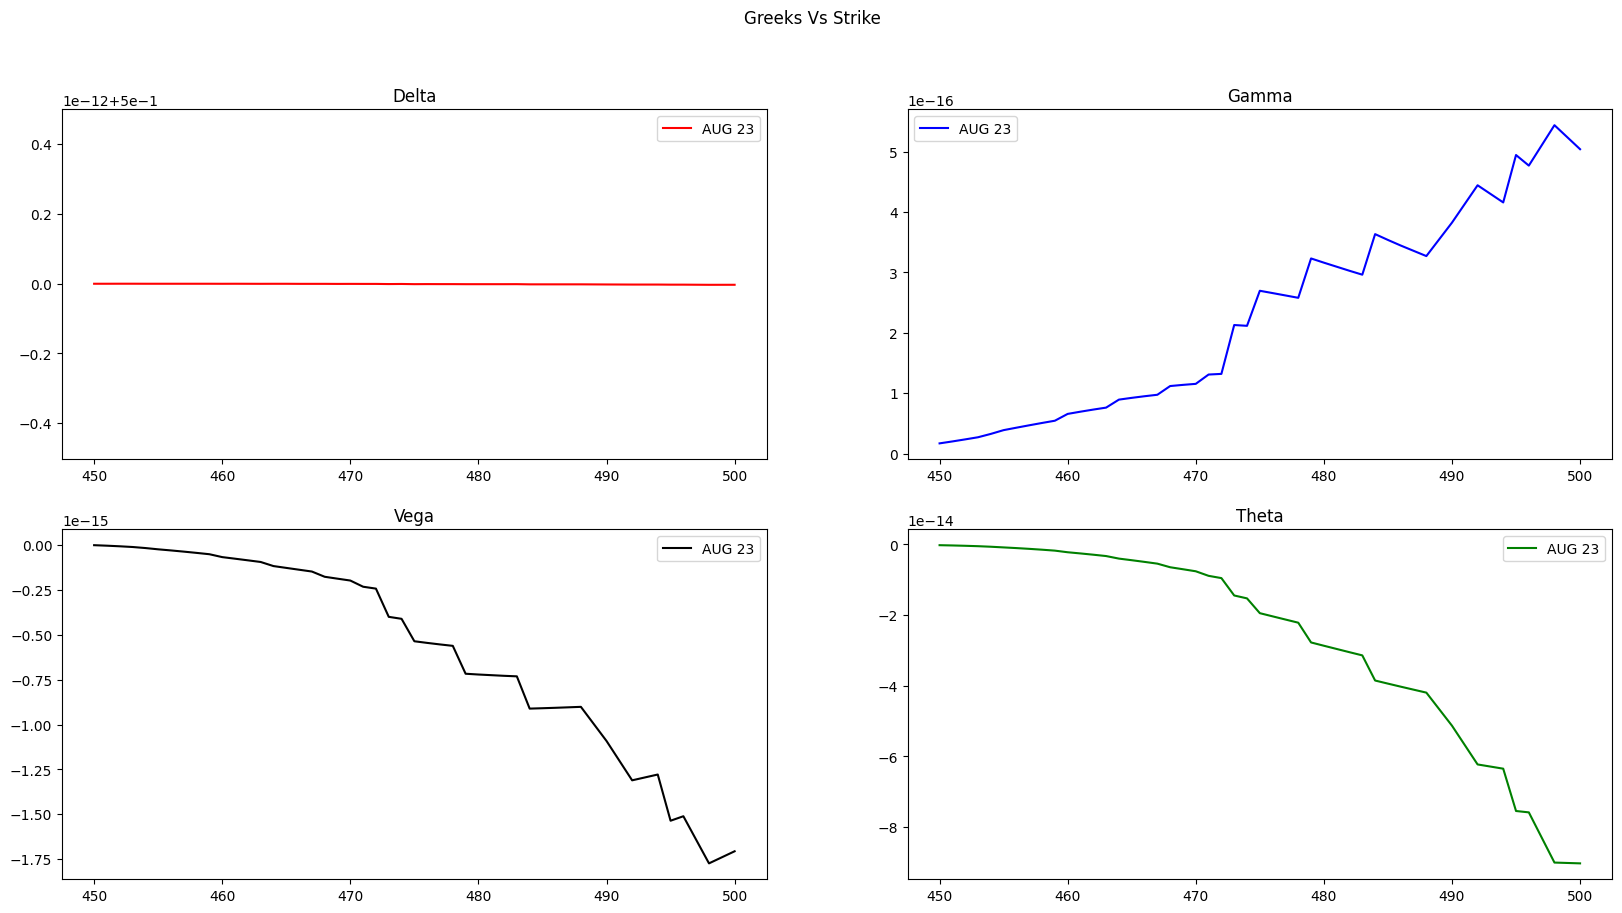

In [16]:
# Plot graph iteratively
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax[0,0].plot(df['Strike'], df['Delta'], color='r', label='AUG 23')
ax[0,1].plot(df['Strike'], df['Gamma'], color='b', label='AUG 23')
ax[1,0].plot(df['Strike'], df['Vega'], color='k', label='AUG 23')
ax[1,1].plot(df['Strike'], df['Theta'], color='g', label='AUG 23')

# Set axis title
ax[0,0].set_title('Delta'), ax[0,1].set_title('Gamma'), ax[1,0].set_title('Vega'), ax[1,1].set_title('Theta')

# Define legend
ax[0,0].legend(), ax[0,1].legend(), ax[1,0].legend(), ax[1,1].legend()

# Set title
fig.suptitle('Greeks Vs Strike')
plt.show()